In [ ]:
!pip install "deeplake<4"
!pip install scipy
!pip install tensorflow
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install --upgrade setuptools
!pip install --upgrade scikit-learn
!pip install --upgrade tensorflow
!pip install --upgrade certifi

In [99]:
from tensorflow.keras.datasets import mnist
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import deeplake
from PIL import Image
import matplotlib.pyplot as plt
import os
from scipy.ndimage import rotate
import random
import ssl
import certifi

ssl_context = ssl.create_default_context(cafile=certifi.where())

In [3]:
# Load MNIST dataset

(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

In [77]:
# Load USPS dataset

usps_train = deeplake.load('hub://activeloop/usps-train', read_only=True)
usps_test = deeplake.load('hub://activeloop/usps-test', read_only=True)

-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/usps-train



|

hub://activeloop/usps-train loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/usps-test



\

hub://activeloop/usps-test loaded successfully.



In [6]:
# Convert USPS train images to NumPy array
usps_train_images = usps_train['images'].numpy()
# Convert USPS train labels to NumPy array and flatten the labels
usps_train_labels = usps_train['labels'].numpy().flatten()

# Convert USPS test images to NumPy array
usps_test_images = usps_test['images'].numpy()
# Convert USPS test labels to NumPy array and flatten the labels
usps_test_labels = usps_test['labels'].numpy().flatten()

# Determine the shape of USPS test images and MNIST train images
usps_image_shape = usps_test_images[0].shape
mnist_image_shape = mnist_train_images[0].shape

# Calculate padding required to match USPS image size to MNIST image size
vert_pad = (mnist_image_shape[0] - usps_image_shape[0]) // 2
horz_pad = (mnist_image_shape[1] - usps_image_shape[1]) // 2

# Apply padding to USPS train images
usps_train_images = np.pad(usps_train_images, ((0, 0), (vert_pad, vert_pad), (horz_pad, horz_pad)), mode='constant', constant_values=0)
# Apply padding to USPS test images
usps_test_images = np.pad(usps_test_images, ((0, 0), (vert_pad, vert_pad), (horz_pad, horz_pad)), mode='constant', constant_values=0)

In [78]:
# Print a single image and its corresponding label
def print_image(image, label):
    print(f'The following is a {label}:')

    # Iterate over each row of pixels in the image
    for row in image:
        r = ''
        for pixel in row:
            # Append space if pixel is 0, otherwise append '##'
            if pixel == 0:
                r = r + '  '
            else:
                r = r + '##'
        print(r)  # Print the constructed string for the row


# Print multiple images and their corresponding labels
def print_images(images, labels):
    # Ensure that the number of images matches the number of labels
    if len(images) != len(labels):
        return

    # Print each image and its corresponding label
    for i in range(len(images)):
        print_image(images[i], labels[i])


# Plot handwritten images in a grid format
def plot_images_in_grid(images, labels, grid_size, size=3, n_th=0, false_labels=np.array([])):
    if false_labels is None:
        false_labels = []

    # Calculate starting index for images to be plotted
    start_image = n_th * grid_size[0] * grid_size[1]

    # Create a grid for plotting the images
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(size * grid_size[1], size * grid_size[0]))

    # Flatten the axes if single row is used
    if grid_size[0] < 2:
        axes = np.ravel(axes)

    # Iterate and plot each image with its label
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            index = start_image + i * grid_size[1] + j
            current_axes = axes[j] if grid_size[0] < 2 else axes[i, j]

            # Plot the image in grayscale
            current_axes.imshow(images[index], cmap='gray')

            # Set title for the subplot, show actual and guessed labels if provided
            if false_labels.size == 0:
                current_axes.set_title(labels[index])
            else:
                current_axes.set_title(f'Actual: {labels[index]}, Guessed: {false_labels[index]}')
            current_axes.axis('off')  # Turn off axis

    plt.show()  # Display the plot

In [80]:
# Helper function to rotate an image by a given degree
def rotate_image(image, degree):
    # Rotate the given image by the specified degree
    # Use 'nearest' mode to fill values near edges
    rotated_image = rotate(image, degree, reshape=False, mode='nearest')
    return rotated_image  # Return the rotated image

# Function to add a random rotation to a list of handwritten images
def add_random_rotation(images):
    # Create a copy of the original images to avoid altering them directly
    rotated_images = np.copy(images)

    # Iterate through each image in the list
    for i in range(len(images)):
        # Generate a random angle between 0 and 360 degrees
        angle = random.uniform(0, 360)

        # Rotate the image randomly and store it back in the list
        rotated_images[i] = rotate_image(images[i], angle)

    return rotated_images  # Return the list of randomly rotated images

In [81]:
# Helper function to create noise for handwritten image
def create_noise(shape, noise_level, noise_probability, noise_constant):
    # Determine whether to add noise based on a random probability
    if random.random() < noise_probability:
        # If noise is constant, use the specified noise level
        if noise_constant:
            noise_level_t = noise_level
        else:
            # Otherwise, randomly choose a level up to the specified noise level
            noise_level_t = random.uniform(0, noise_level)

        # Generate Gaussian noise based on the noise level
        noise = np.random.normal(0, noise_level_t, shape)
    else:
        # No noise is added if probability condition is not met
        noise = np.zeros(shape)

    return noise

# Function to add random noise to a list of handwritten images
def add_random_noise(images, noise_level, noise_probability=1, noise_constant=True):
    # Get the shape of a single image
    image_shape = images[0].shape

    # Create a copy of the images to avoid modifying the original
    noisy_images = np.copy(images)

    # Create noise for each image
    noise = [create_noise(image_shape, noise_level, noise_probability, noise_constant) for _ in range(len(images))]

    # Add the generated noise to each image
    noisy_images = noisy_images + noise

    # Clip the noisy images' pixel values to be between 0 and 255 to ensure valid pixel values
    noisy_images = np.clip(noisy_images, 0, 255)

    return noisy_images

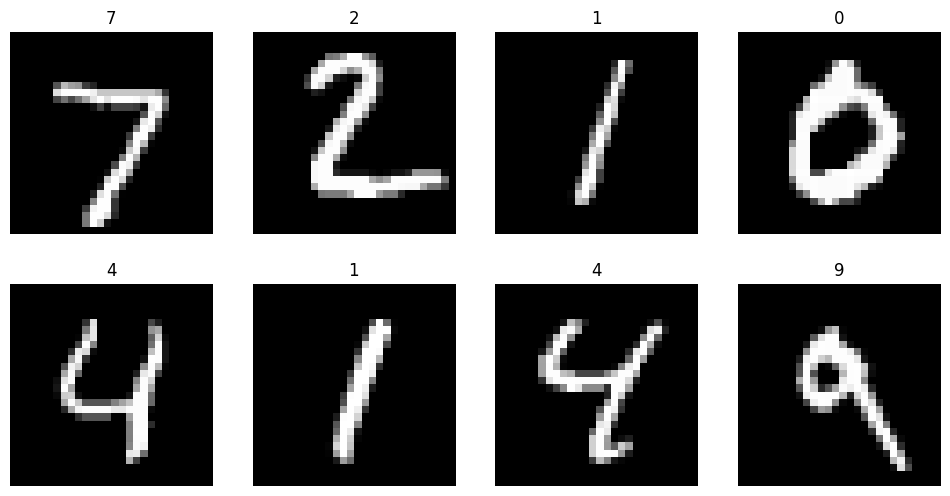

In [82]:
# Print out elements from MNIST dataset
plot_images_in_grid(mnist_test_images, mnist_test_labels, (2, 4))

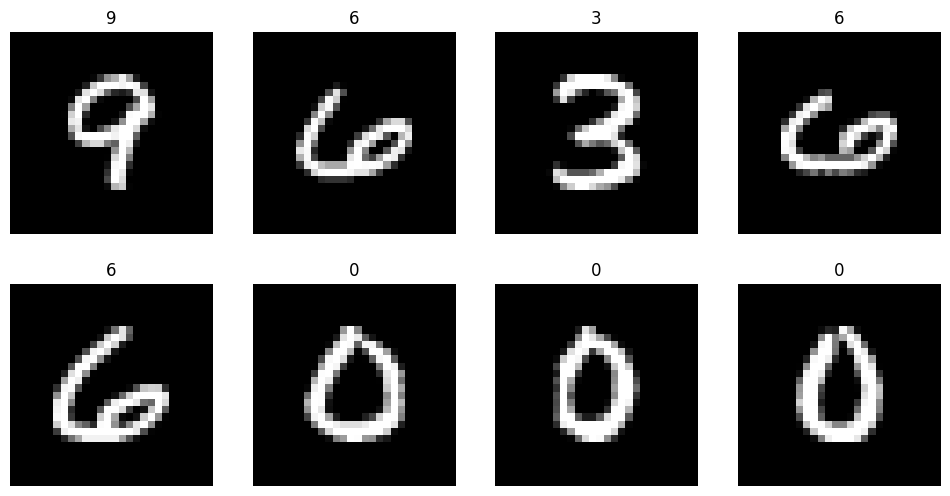

In [83]:
# Print out elements from USPS dataset
plot_images_in_grid(usps_test_images, usps_test_labels, (2,4))

In [84]:
# Add random noise to some of the handwritten digits

# Define the maximum noise level
NOISE_MAX = 100

# Define the probability of adding noise
NOISE_PROB = 0.75

# Define whether the noise level is constant or variable
NOISE_CONST = False

# Add random noise to the MNIST training images
mnist_noisy_train_images = add_random_noise(mnist_train_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)

# Add random noise to the MNIST testing images
mnist_noisy_test_images = add_random_noise(mnist_test_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)

# Add random noise to the USPS training images
usps_noisy_train_images = add_random_noise(usps_train_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)

# Add random noise to the USPS testing images
usps_noisy_test_images = add_random_noise(usps_test_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)

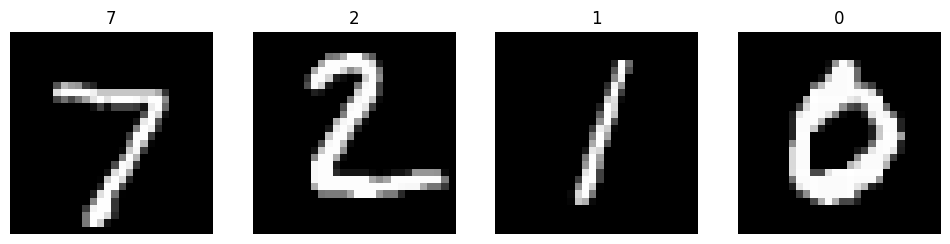

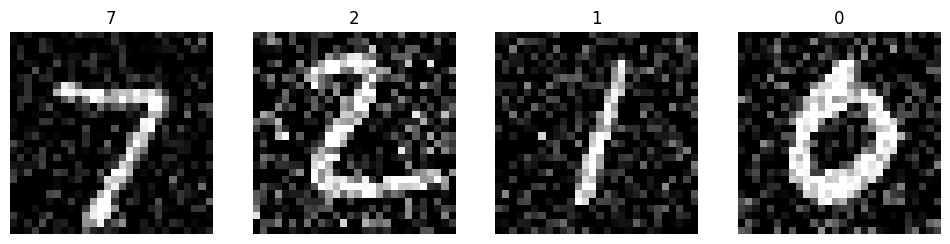

In [13]:
# Print out new versus original elements from MNIST dataset
plot_images_in_grid(mnist_test_images, mnist_test_labels, (1,4))
plot_images_in_grid(mnist_noisy_test_images, mnist_test_labels, (1,4))

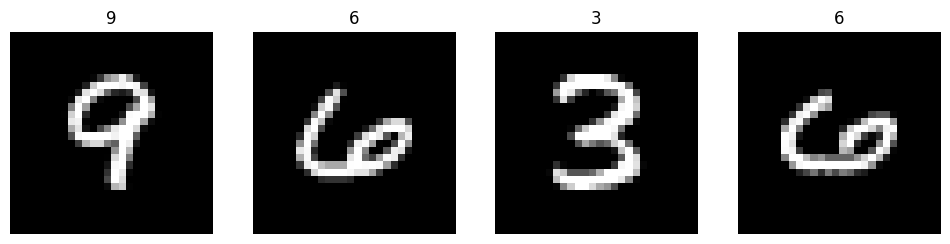

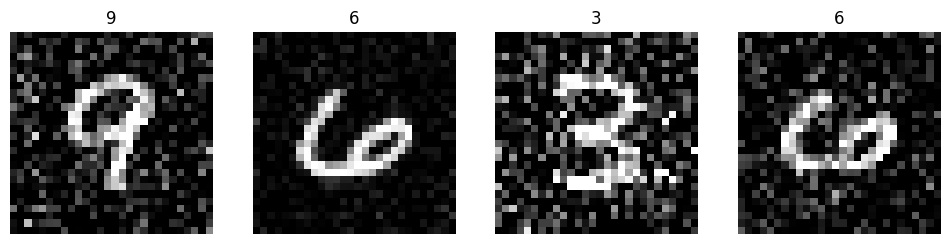

In [14]:
# Print out new versus original elements from USPS dataset
plot_images_in_grid(usps_test_images, usps_test_labels, (1,4))
plot_images_in_grid(usps_noisy_test_images, usps_test_labels, (1,4))

In [15]:
# Create various other datasets for testing

# 25% max noise
mnist_noisy25_test_images = add_random_noise(mnist_test_images, NOISE_MAX // 4)
usps_noisy25_test_images = add_random_noise(usps_test_images, NOISE_MAX // 4)

# 50% max noise
mnist_noisy50_test_images = add_random_noise(mnist_test_images, NOISE_MAX // 2)
usps_noisy50_test_images = add_random_noise(usps_test_images, NOISE_MAX // 2)

# 100% max noise
mnist_noisy100_test_images = add_random_noise(mnist_test_images, NOISE_MAX)
usps_noisy100_test_images = add_random_noise(usps_test_images, NOISE_MAX)

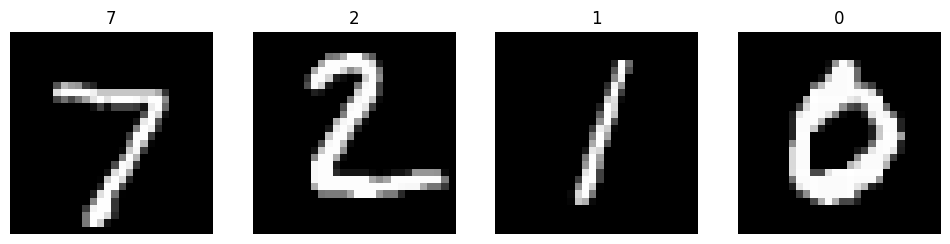

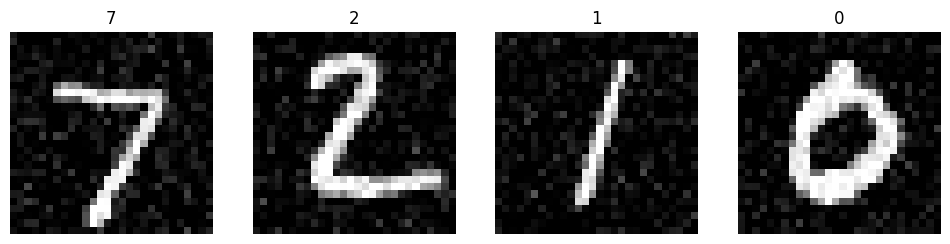

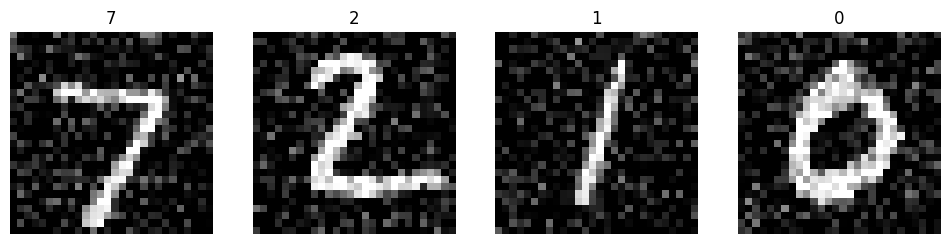

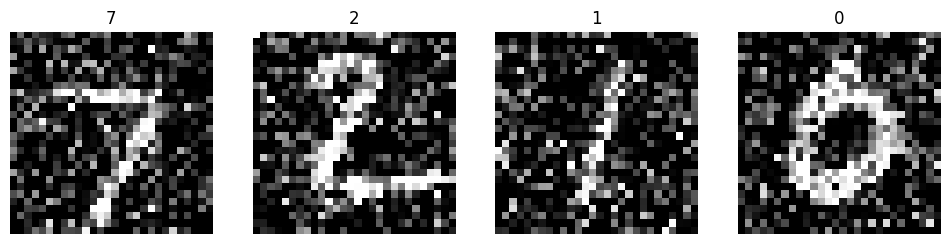

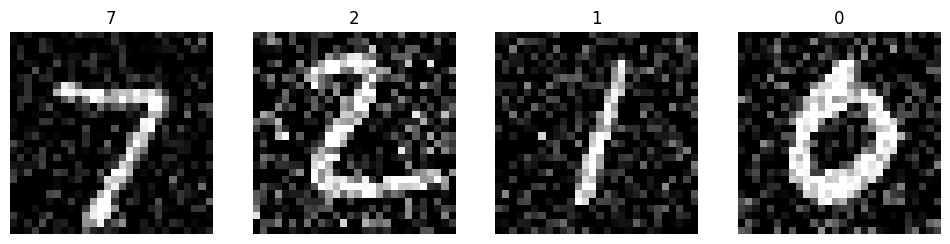

In [16]:
# Plot all the different testing datasets from MNIST
plot_images_in_grid(mnist_test_images, mnist_test_labels, (1,4))
plot_images_in_grid(mnist_noisy25_test_images, mnist_test_labels, (1,4))
plot_images_in_grid(mnist_noisy50_test_images, mnist_test_labels, (1,4))
plot_images_in_grid(mnist_noisy100_test_images, mnist_test_labels, (1,4))
plot_images_in_grid(mnist_noisy_test_images, mnist_test_labels, (1,4))

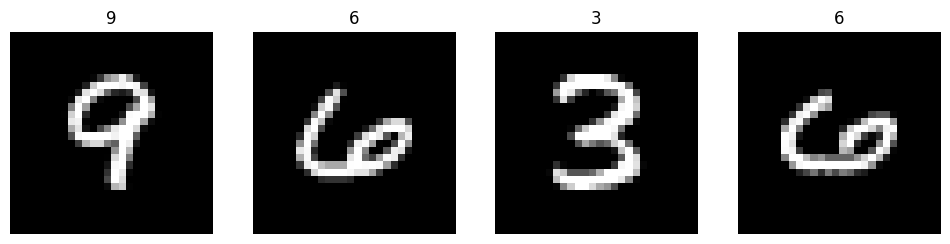

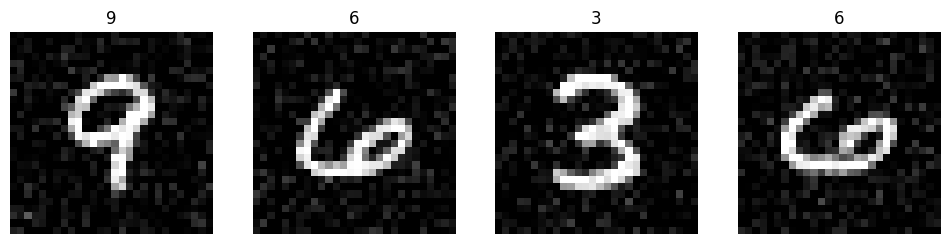

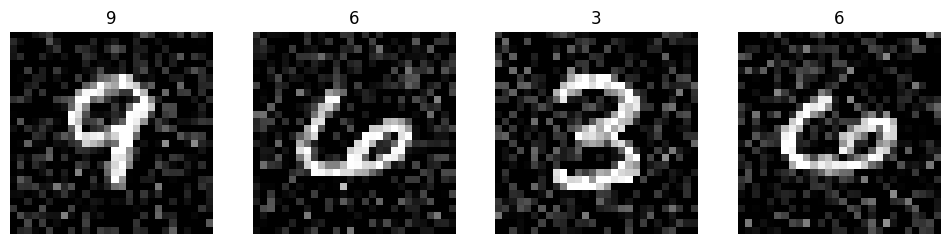

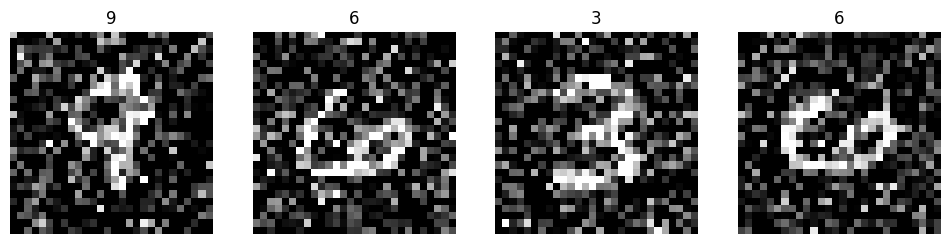

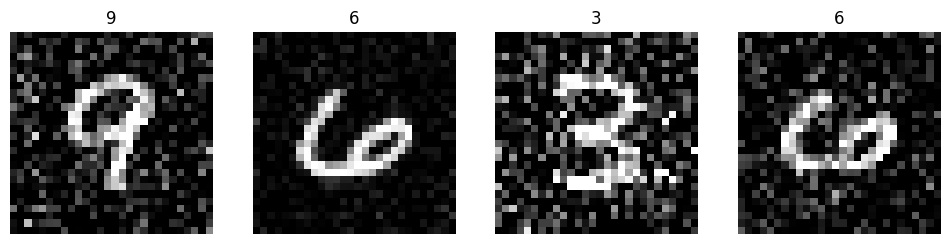

In [17]:
# Plot all the different testing datasets from USPS
plot_images_in_grid(usps_test_images, usps_test_labels, (1,4))
plot_images_in_grid(usps_noisy25_test_images, usps_test_labels, (1,4))
plot_images_in_grid(usps_noisy50_test_images, usps_test_labels, (1,4))
plot_images_in_grid(usps_noisy100_test_images, usps_test_labels, (1,4))
plot_images_in_grid(usps_noisy_test_images, usps_test_labels, (1,4))

In [86]:
# Combine training and testing images and labels from MNIST and USPS
combined_train_images = np.vstack((mnist_train_images, usps_train_images))
combined_test_images = np.vstack((mnist_test_images, usps_test_images))

combined_noisy_train_images = np.vstack((mnist_noisy_train_images, usps_noisy_train_images))
combined_noisy_test_images = np.vstack((mnist_noisy_test_images, usps_noisy_test_images))

combined_train_labels = np.append(mnist_train_labels, usps_train_labels)
combined_test_labels = np.append(mnist_test_labels, usps_test_labels)

# Rotate and add noise to datasets
combined_rotated_train_images = add_random_rotation(combined_train_images)
combined_rotated_test_images = add_random_rotation(combined_test_images)

combined_rotated_noisy_train_images = add_random_noise(combined_rotated_train_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)
combined_rotated_noisy_test_images = add_random_noise(combined_rotated_test_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)

In [87]:
# Function to compute and display statistics for a dataset
def get_statistics(training_labels, testing_labels, name, get_split=False):

    # Count occurrences of each label in training and testing datasets
    training_counts = np.bincount(training_labels)
    testing_counts = np.bincount(testing_labels)

    # Total counts for each label across both datasets
    full_counts = training_counts + testing_counts

    # Create labels for the x-axis of the bar graph
    labels = [i for i in range(10)]

    # Create a bar graph showing counts for training and testing sets
    plt.bar(labels, training_counts, label='Training Set', color='blue')
    plt.bar(labels, testing_counts, bottom=training_counts, label='Testing Set', color='orange')
    plt.xticks(np.arange(len(labels)), labels)

    # Add labels and a title to the plot
    plt.xlabel('Digit')
    plt.ylabel('Count')
    plt.title(name)

    # Display the legend
    plt.legend()

    # Show the plot
    plt.show()

    # If detailed split statistics are requested
    if get_split:
        # Print statistics for the entire dataset
        print(f'Showing statistics for full {name} dataset:')
        print(f' {len(training_labels) + len(testing_labels)} total rows:')
        for digit in range(len(full_counts)):
            print(f'   {digit}: {full_counts[digit]} ({100 * (full_counts[digit]/(len(training_labels) + len(testing_labels))):.3f}%)')

        # Print statistics for the training dataset
        print(f'Showing statistics for {name} training dataset:')
        print(f' {len(training_labels)} total rows:')
        for digit in range(len(training_counts)):
            print(f'   {digit}: {training_counts[digit]} ({100 * (training_counts[digit]/len(training_labels)):.3f}%)')

        # Print statistics for the testing dataset
        print(f'Showing statistics for {name} testing dataset:')
        print(f' {len(testing_labels)} total rows:')
        for digit in range(len(testing_counts)):
            print(f'   {digit}: {testing_counts[digit]} ({100 * (testing_counts[digit]/len(testing_labels)):.3f}%)')

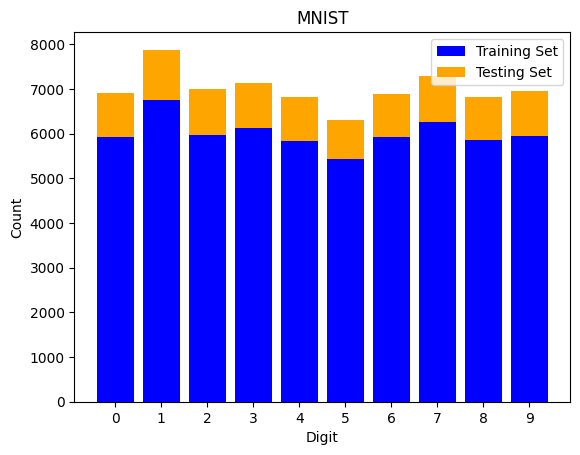

In [88]:
# Statistics about MNIST
get_statistics(mnist_train_labels, mnist_test_labels, 'MNIST')

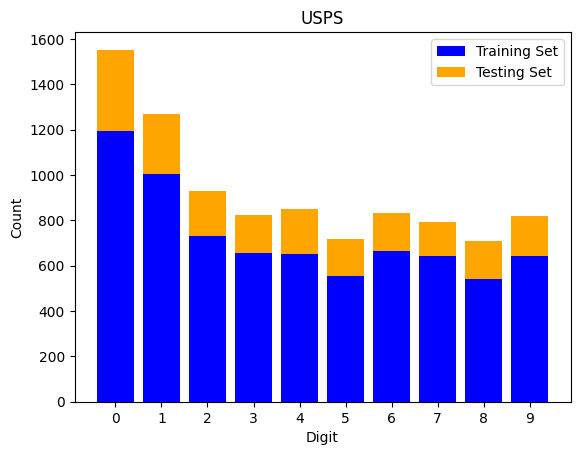

In [89]:
# Statistics about USPS
get_statistics(usps_train_labels, usps_test_labels, 'USPS')

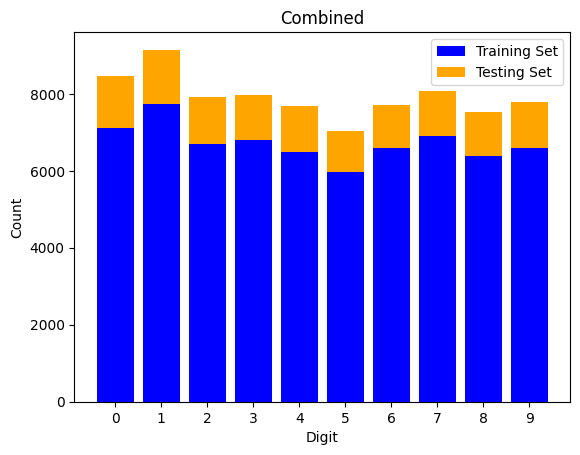

In [22]:
get_statistics(combined_train_labels, combined_test_labels, 'Combined')

In [90]:
# Creating model
input_shape = mnist_image_shape

LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 15

# Define the CNN model
model = models.Sequential()

model.add(layers.Reshape((input_shape[0], input_shape[1], 1), input_shape=input_shape))

# Convolution Layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before the fully connected layers
model.add(layers.Flatten())

# Fully Connected Layer 1
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

/Users/amoskowitz/Desktop/Projects/Stevens/HandwrittenDigitClassification/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Evaluates the model using test images and labels and prints the evaluation metrics
def eval_model(my_model, test_images, test_labels, name):
  # Get predictions from the model
  test_predictions = my_model.predict(test_images)
  # Convert predictions to class labels
  test_predictions_classes = tf.argmax(test_predictions, axis=1)

  # Calculate evaluation metrics
  accuracy = accuracy_score(test_labels, test_predictions_classes)
  precision = precision_score(test_labels, test_predictions_classes, average='weighted', zero_division=0)
  recall = recall_score(test_labels, test_predictions_classes, average='weighted', zero_division=0)
  f1 = f1_score(test_labels, test_predictions_classes, average='weighted', zero_division=0)

  # Print evaluation results
  print(f'Testing Done Using {name} Dataset:')
  print(f'Accuracy: {accuracy:.4f}')
  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1-Score: {f1:.4f}')


# Evaluate the model on various datasets and print the results
def eval_all(my_model, include_rotated=False):
  print('MNIST:')
  # Evaluate on different noise levels for MNIST
  eval_model(my_model, mnist_test_images, mnist_test_labels, 'MNIST Clean')
  eval_model(my_model, mnist_noisy_test_images, mnist_test_labels, 'MNIST Mixed')
  eval_model(my_model, mnist_noisy25_test_images, mnist_test_labels, 'MNIST 25%')
  eval_model(my_model, mnist_noisy50_test_images, mnist_test_labels, 'MNIST 50%')
  eval_model(my_model, mnist_noisy100_test_images, mnist_test_labels, 'MNIST 100%')

  print('\nUSPS:')
  # Evaluate on different noise levels for USPS
  eval_model(my_model, usps_test_images, usps_test_labels, 'USPS Clean')
  eval_model(my_model, usps_noisy_test_images, usps_test_labels, 'USPS Mixed')
  eval_model(my_model, usps_noisy25_test_images, usps_test_labels, 'USPS 25%')
  eval_model(my_model, usps_noisy50_test_images, usps_test_labels, 'USPS 50%')
  eval_model(my_model, usps_noisy100_test_images, usps_test_labels, 'USPS 100%')

  print('\nCombined:')
  # Evaluate on combined datasets, optionally including rotations
  eval_model(my_model, combined_test_images, combined_test_labels, 'Combined Clean')
  eval_model(my_model, combined_noisy_test_images, combined_test_labels, 'Combined Mixed')

  if include_rotated:
    eval_model(my_model, combined_rotated_test_images, combined_test_labels, 'Combined Clean Rotated')
    eval_model(my_model, combined_rotated_noisy_test_images, combined_test_labels, 'Combined Mixed Rotated')

In [92]:
# Finds the accuracy between model predictions and true labels
def find_accuracy(my_model, test_images, test_labels):
    # Predict classes for test images
    test_predictions = my_model.predict(test_images)
    test_predictions_classes = tf.argmax(test_predictions, axis=1)

    # Calculate and return the accuracy
    accuracy = accuracy_score(test_labels, test_predictions_classes)
    return accuracy

# Trains a model with the given parameters and evaluates accuracy
def train_fit(my_model, train_images, train_labels, test_images, test_labels, epochs, batch_size, learning_rate):
    # Clone the model to ensure a fresh start for each trial
    trial_model = clone_model(my_model)
    trial_model.set_weights(model.get_weights())
    trial_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                        loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Fit the model on training data
    trial_model.fit(train_images, train_labels, epochs=epochs,
                    batch_size=batch_size, validation_data=(test_images, test_labels))

    # Return the accuracy on test data
    return find_accuracy(trial_model, test_images, test_labels)

# Finds optimal hyperparameters (epochs, batch size, learning rate) for the model
def find_optimal_fit(my_model, train_images, train_labels, test_images, test_labels):
    max_trials = 3  # Number of trials to run
    # Options for hyperparameters
    epoch_options = [5, 10, 15, 20]
    batch_sizes = [16, 32, 64, 128]
    learning_rates = [0.01, 0.001, 0.0001, 0.00001]

    # Initialize 'best' variables
    last_epochs = -1
    last_batch_size = -1
    last_learning_rate = -1

    # Start with the first option as "best" values
    best_epochs = epoch_options[0]
    best_batch_size = batch_sizes[0]
    best_learning_rate = learning_rates[0]

    ret = np.array([])

    # Loop through trials to optimize hyperparameters
    for trial in range(1, max_trials + 1):
        print(f'Trial {trial}:')

        # Track best accuracy for each parameter type
        epoch_acc = 0
        batch_size_acc = 0
        learning_rate_acc = 0

        # Optimize learning rate
        print(f'Optimizing learning rate with epochs: {best_epochs} and batch size {best_batch_size}')
        for cur_learning_rate in learning_rates:
            print(f'Testing learning rate = {cur_learning_rate} with epochs: {best_epochs} and batch size: {best_batch_size}')
            cur_acc = train_fit(my_model, train_images, train_labels, test_images, test_labels,
                                best_epochs, best_batch_size, cur_learning_rate)

            # Update if a new best learning rate is found
            if cur_acc > learning_rate_acc:
                learning_rate_acc = cur_acc
                best_learning_rate = cur_learning_rate

        # Optimize batch size
        print(f'Optimizing batch size with epochs: {best_epochs} and learning rate {best_learning_rate}')
        for cur_batch_size in batch_sizes:
            print(f'Testing batch size = {cur_batch_size} with epochs: {best_epochs} and learning rate {best_learning_rate}')
            cur_acc = train_fit(my_model, train_images, train_labels, test_images, test_labels,
                                best_epochs, cur_batch_size, best_learning_rate)

            # Update if a new best batch size is found
            if cur_acc > batch_size_acc:
                batch_size_acc = cur_acc
                best_batch_size = cur_batch_size

        # Optimize epochs
        print(f'Optimizing epochs with batch size: {best_batch_size} and learning rate {best_learning_rate}')
        for cur_epochs in epoch_options:
            print(f'Testing epochs = {cur_epochs} with batch size: {best_batch_size} and learning rate {best_learning_rate}')
            cur_acc = train_fit(my_model, train_images, train_labels, test_images, test_labels,
                                cur_epochs, best_batch_size, best_learning_rate)

            # Update if a new best epoch count is found
            if cur_acc > epoch_acc:
                epoch_acc = cur_acc
                best_epochs = cur_epochs

        print(f'Hyperparameters after trial {trial}:\nEpochs: {best_epochs}\nBatch Size: {best_batch_size}\nLearning Rate: {best_learning_rate}')

        # Store results for each trial
        ret = np.append(ret, (best_epochs, best_batch_size, best_learning_rate, learning_rate_acc))

        # Exit if no improvement
        if last_epochs == best_epochs and last_batch_size == best_batch_size and last_learning_rate == best_learning_rate:
            return ret
        else:
            # Update last known best parameters
            last_epochs = best_epochs
            last_batch_size = best_batch_size
            last_learning_rate = best_learning_rate

    return ret

In [47]:
# Creating a copy of model structure to train using clean data
clean_model = clone_model(model)
clean_model.set_weights(model.get_weights())
clean_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
# res = find_optimal_fit(clean_model, combined_noisy_train_images, combined_train_labels, combined_noisy_test_images, combined_test_labels)

In [164]:
# Fit the clean_model on the combined training dataset
# Using specified number of epochs and batch size
# Also validating on the combined test dataset
clean_model.fit(combined_train_images, combined_train_labels,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=(combined_test_images, combined_test_labels))

Epoch 1/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8092 - loss: 1.1719 - val_accuracy: 0.9582 - val_loss: 0.1481
Epoch 2/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9642 - loss: 0.1180 - val_accuracy: 0.9694 - val_loss: 0.1081
Epoch 3/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9767 - loss: 0.0729 - val_accuracy: 0.9758 - val_loss: 0.0821
Epoch 4/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9848 - loss: 0.0479 - val_accuracy: 0.9781 - val_loss: 0.0811
Epoch 5/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9888 - loss: 0.0342 - val_accuracy: 0.9818 - val_loss: 0.0665
Epoch 6/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9915 - loss: 0.0261 - val_accuracy: 0.9801 - val_loss: 0.0749
Epoch 7/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9936 - loss: 0.0195 - val_accuracy: 0.9792 - val_loss: 0.0788
Epoch 8/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9950 - loss: 0

In [165]:
# Save model
clean_model.save('./Models/clean_model.keras')

In [49]:
# Load model
clean_model = load_model('./Models/clean_model.keras')

In [50]:
# Evaluating the clean_model
eval_all(clean_model)

MNIST:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Clean Dataset:
Accuracy: 0.9836
Precision: 0.9838
Recall: 0.9836
F1-Score: 0.9836
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Mixed Dataset:
Accuracy: 0.8264
Precision: 0.9108
Recall: 0.8264
F1-Score: 0.8458
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 25% Dataset:
Accuracy: 0.9755
Precision: 0.9762
Recall: 0.9755
F1-Score: 0.9755
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 50% Dataset:
Accuracy: 0.8743
Precision: 0.9142
Recall: 0.8743
F1-Score: 0.8814
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 100% Dataset:
Accuracy: 0.3381
Precision: 0.8293
Recall: 0.3381
F1-Score: 0.3317

USPS:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Testing Done Using USPS Clean Dataset:
Accuracy: 0.9716
Precision: 0.9719
Recall: 0.9716
F1-Score: 0.9716
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Testing Done Using USPS Mixed Dataset:
Accuracy: 0.7843
Precision: 

In [51]:
# Creating a copy of model structure to train using mixed data
mixed_model = clone_model(model)
mixed_model.set_weights(model.get_weights())
mixed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [169]:
# Train the mixed model using the noisy training dataset
# Using the specified number of epochs and batch size
# Validate the model using the noisy test dataset
mixed_model.fit(
    combined_noisy_train_images,
    combined_train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(combined_noisy_test_images, combined_test_labels))

Epoch 1/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.7509 - loss: 1.3500 - val_accuracy: 0.9347 - val_loss: 0.2259
Epoch 2/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9474 - loss: 0.1736 - val_accuracy: 0.9567 - val_loss: 0.1459
Epoch 3/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9663 - loss: 0.1119 - val_accuracy: 0.9648 - val_loss: 0.1273
Epoch 4/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9753 - loss: 0.0815 - val_accuracy: 0.9686 - val_loss: 0.1182
Epoch 5/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9812 - loss: 0.0588 - val_accuracy: 0.9658 - val_loss: 0.1272
Epoch 6/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9872 - loss: 0.0416 - val_accuracy: 0.9685 - val_loss: 0.1250
Epoch 7/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9896 - loss: 0.0327 - val_accuracy: 0.9718 - val_loss: 0.1151
Epoch 8/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9913 - loss: 0

In [170]:
# Save model
mixed_model.save('./Models/mixed_model.keras')

In [52]:
# Load model
mixed_model = load_model('./Models/mixed_model.keras')

In [93]:
# Evaluate the mixed_model
eval_all(mixed_model)

MNIST:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Clean Dataset:
Accuracy: 0.9849
Precision: 0.9850
Recall: 0.9849
F1-Score: 0.9849
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Mixed Dataset:
Accuracy: 0.9781
Precision: 0.9782
Recall: 0.9781
F1-Score: 0.9781
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 25% Dataset:
Accuracy: 0.9840
Precision: 0.9841
Recall: 0.9840
F1-Score: 0.9840
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 50% Dataset:
Accuracy: 0.9792
Precision: 0.9793
Recall: 0.9792
F1-Score: 0.9792
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 100% Dataset:
Accuracy: 0.9434
Precision: 0.9446
Recall: 0.9434
F1-Score: 0.9434

USPS:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Clean Dataset:
Accuracy: 0.9626
Precision: 0.9634
Recall: 0.9626
F1-Score: 0.9627
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Mixed Dataset:
Accuracy: 0.9487
Precision: 

In [94]:
# Function to plot incorrect predictions for a single dataset
def plot_incorrect(my_model, test_images, test_labels, title):

    # Predict labels for the test images
    pred = my_model.predict(test_images)
    pred_bin = [np.argmax(x) for x in pred]

    # Identify indices where predictions do not match the actual labels
    incorrect_pred = np.where(pred_bin != test_labels)
    correct_pred = test_labels[incorrect_pred]

    # Count occurrences of incorrect predictions for each digit
    count_incorrect = np.bincount(correct_pred)

    # Create labels for each digit in the dataset
    labels = [i for i in range(10)]

    # Generate a bar graph representing incorrect predictions
    plt.bar(labels, count_incorrect)
    plt.xticks(np.arange(len(labels)), labels)

    # Add axis titles and a main title to the graph
    plt.xlabel('Digit')
    plt.ylabel('Count Incorrect')
    plt.title(title)

    # Display the plot
    plt.show()

# Function to plot incorrect predictions for two datasets
def plot_incorrect_2(my_model, test_images_1, test_images_2, test_labels_1, test_labels_2, title, name_1, name_2):

    # Predict labels for the first dataset's test images
    pred = my_model.predict(test_images_1)
    pred_bin = [np.argmax(x) for x in pred]

    # Identify incorrect predictions for the first dataset
    incorrect_pred = np.where(pred_bin != test_labels_1)
    correct_pred = test_labels_1[incorrect_pred]
    count_incorrect_1 = np.bincount(correct_pred)

    # Predict labels for the second dataset's test images
    pred = my_model.predict(test_images_2)
    pred_bin = [np.argmax(x) for x in pred]

    # Identify incorrect predictions for the second dataset
    incorrect_pred = np.where(pred_bin != test_labels_2)
    correct_pred = test_labels_2[incorrect_pred]
    count_incorrect_2 = np.bincount(correct_pred)

    # Create labels for each digit in both datasets
    labels = [i for i in range(10)]

    # Generate a stacked bar graph comparing incorrect predictions
    plt.bar(labels, count_incorrect_1, label=name_1, color='blue')
    plt.bar(labels, count_incorrect_2, bottom=count_incorrect_1, label=name_2, color='orange')
    plt.xticks(np.arange(len(labels)), labels)

    # Add axis titles and a main title to the graph
    plt.xlabel('Actual Digit')
    plt.ylabel('Count Incorrect')
    plt.title(title)
    plt.legend()

    # Display the plot
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


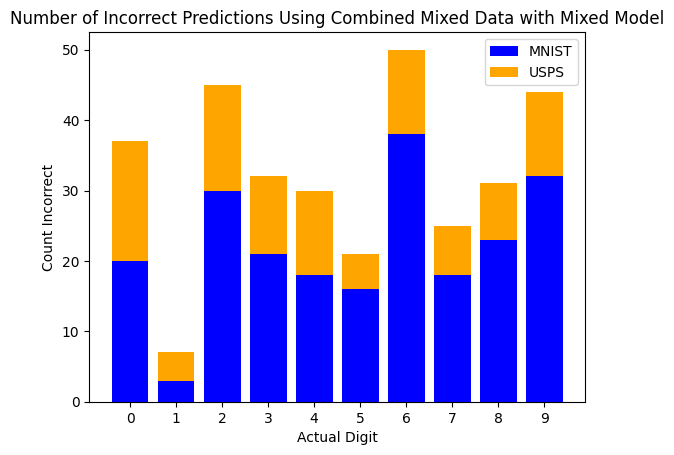

In [95]:
plot_incorrect_2(mixed_model, mnist_noisy_test_images, usps_noisy_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Mixed Data with Mixed Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


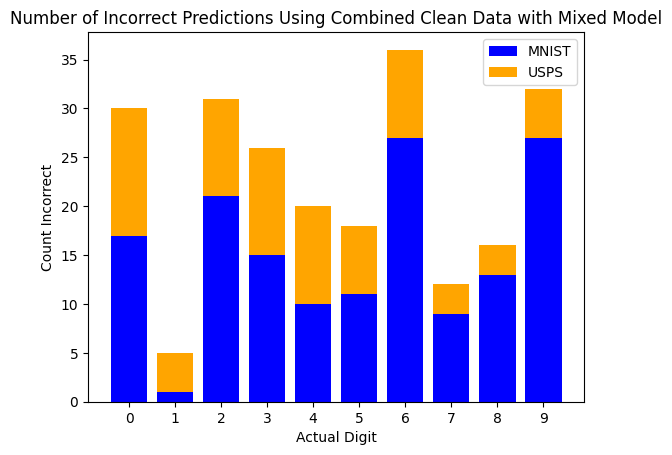

In [96]:
plot_incorrect_2(mixed_model, mnist_test_images, usps_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Clean Data with Mixed Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


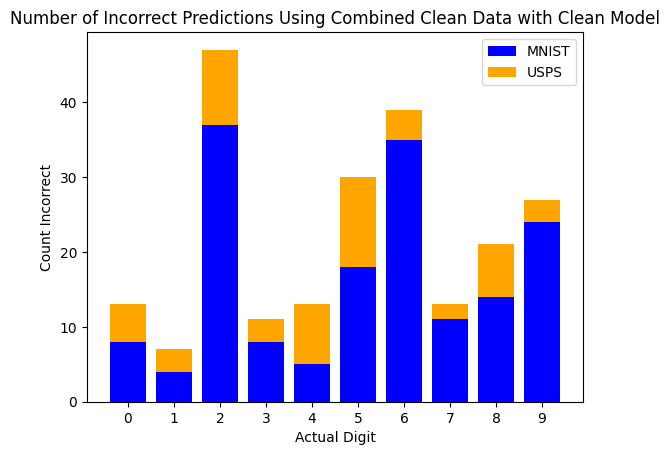

In [58]:
plot_incorrect_2(clean_model, mnist_test_images, usps_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Clean Data with Clean Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


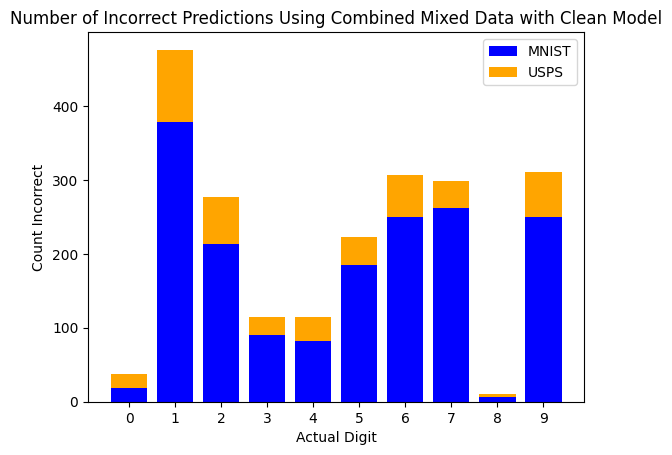

In [59]:
plot_incorrect_2(clean_model, mnist_noisy_test_images, usps_noisy_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Mixed Data with Clean Model', 'MNIST', 'USPS')

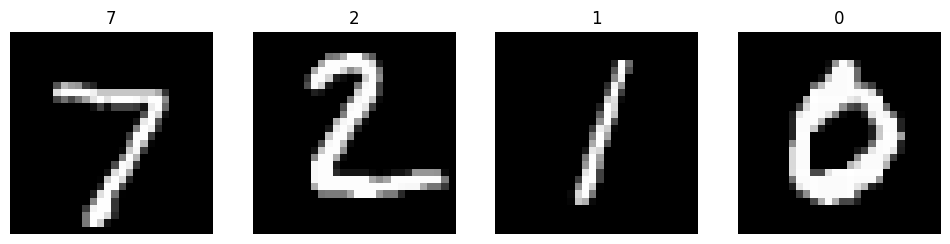

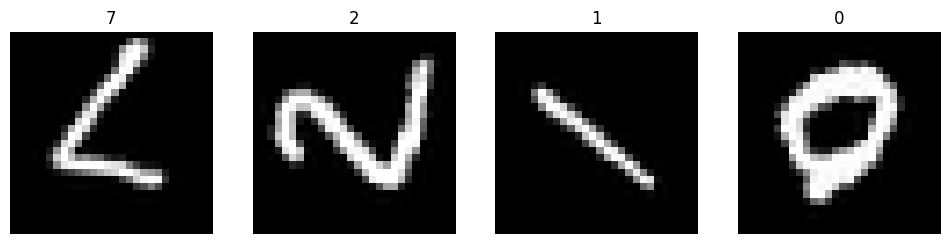

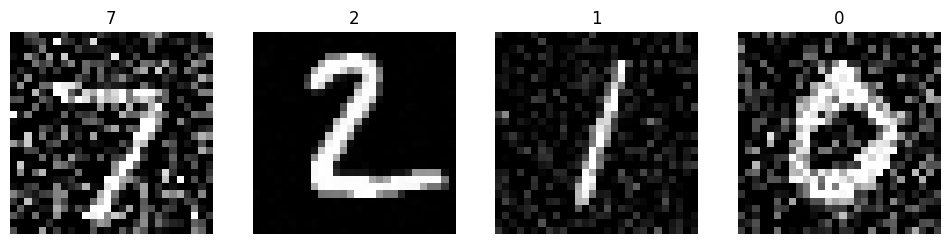

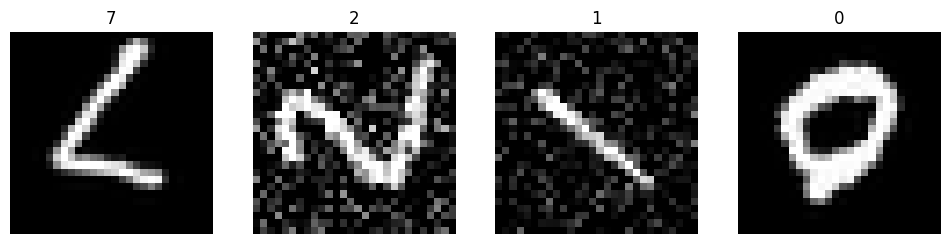

In [97]:
# Testing with rotated datasets
plot_images_in_grid(combined_test_images, combined_test_labels, (1,4))
plot_images_in_grid(combined_rotated_test_images, combined_test_labels, (1,4))

plot_images_in_grid(combined_noisy_test_images, combined_test_labels, (1,4))
plot_images_in_grid(combined_rotated_noisy_test_images, combined_test_labels, (1,4))

In [61]:
rotated_clean_model = clone_model(model)
rotated_clean_model.set_weights(model.get_weights())
rotated_clean_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [180]:
rotated_clean_model.fit(combined_rotated_train_images, combined_train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(combined_rotated_test_images, combined_test_labels))

Epoch 1/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.4888 - loss: 2.2729 - val_accuracy: 0.8043 - val_loss: 0.6170
Epoch 2/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8228 - loss: 0.5533 - val_accuracy: 0.8702 - val_loss: 0.4152
Epoch 3/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8853 - loss: 0.3617 - val_accuracy: 0.8876 - val_loss: 0.3525
Epoch 4/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9149 - loss: 0.2642 - val_accuracy: 0.9053 - val_loss: 0.3029
Epoch 5/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9291 - loss: 0.2146 - val_accuracy: 0.9073 - val_loss: 0.2956
Epoch 6/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9422 - loss: 0.1744 - val_accuracy: 0.9226 - val_loss: 0.2609
Epoch 7/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9523 - loss: 0.1469 - val_accuracy: 0.9142 - val_loss: 0.2903
Epoch 8/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9609 - loss: 0

In [181]:
# Save model
rotated_clean_model.save('./Models/rotated_clean_model.keras')

In [62]:
# Load model
rotated_clean_model = load_model('./Models/rotated_clean_model.keras')

In [63]:
# Evaluate the mixed_clean_model
eval_all(rotated_clean_model, True)

MNIST:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Clean Dataset:
Accuracy: 0.9277
Precision: 0.9292
Recall: 0.9277
F1-Score: 0.9279
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Mixed Dataset:
Accuracy: 0.5789
Precision: 0.8372
Recall: 0.5789
F1-Score: 0.6399
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 25% Dataset:
Accuracy: 0.8750
Precision: 0.8894
Recall: 0.8750
F1-Score: 0.8760
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 50% Dataset:
Accuracy: 0.3653
Precision: 0.7588
Recall: 0.3653
F1-Score: 0.3899
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 100% Dataset:
Accuracy: 0.0985
Precision: 0.1967
Recall: 0.0985
F1-Score: 0.0195

USPS:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Clean Dataset:
Accuracy: 0.8660
Precision: 0.8704
Recall: 0.8660
F1-Score: 0.8668
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Mixed Dataset:
Accuracy: 0.5162
Precision: 

In [64]:
rotated_mixed_model = clone_model(model)
rotated_mixed_model.set_weights(model.get_weights())
rotated_mixed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [185]:
rotated_mixed_model.fit(combined_rotated_noisy_train_images, combined_train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(combined_rotated_noisy_test_images, combined_test_labels))

Epoch 1/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.4062 - loss: 2.5128 - val_accuracy: 0.7030 - val_loss: 0.8997
Epoch 2/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7457 - loss: 0.7722 - val_accuracy: 0.8084 - val_loss: 0.5876
Epoch 3/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8405 - loss: 0.4980 - val_accuracy: 0.8448 - val_loss: 0.4777
Epoch 4/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8755 - loss: 0.3864 - val_accuracy: 0.8624 - val_loss: 0.4352
Epoch 5/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8993 - loss: 0.3128 - val_accuracy: 0.8798 - val_loss: 0.3930
Epoch 6/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9171 - loss: 0.2561 - val_accuracy: 0.8847 - val_loss: 0.3677
Epoch 7/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9285 - loss: 0.2212 - val_accuracy: 0.8876 - val_loss: 0.3701
Epoch 8/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9381 - loss: 0

In [186]:
# Save model
rotated_clean_model.save('./Models/rotated_mixed_model.keras')

In [65]:
# Load model
rotated_clean_model = load_model('./Models/rotated_mixed_model.keras')

In [98]:
# Evaluate the rotated_mixed_model
eval_all(rotated_mixed_model, True)

MNIST:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Testing Done Using MNIST Clean Dataset:
Accuracy: 0.0980
Precision: 0.0590
Recall: 0.0980
F1-Score: 0.0375
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Mixed Dataset:
Accuracy: 0.1015
Precision: 0.0611
Recall: 0.1015
F1-Score: 0.0337
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Testing Done Using MNIST 25% Dataset:
Accuracy: 0.0974
Precision: 0.0486
Recall: 0.0974
F1-Score: 0.0303
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 50% Dataset:
Accuracy: 0.1000
Precision: 0.0452
Recall: 0.1000
F1-Score: 0.0267
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 100% Dataset:
Accuracy: 0.1024
Precision: 0.0521
Recall: 0.1024
F1-Score: 0.0278

USPS:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Clean Dataset:
Accuracy: 0.0732
Precision: 0.0375
Recall: 0.0732
F1-Score: 0.0220
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Testing Done Using USPS Mixed Dataset:
Accuracy: 0.0762
Precision: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


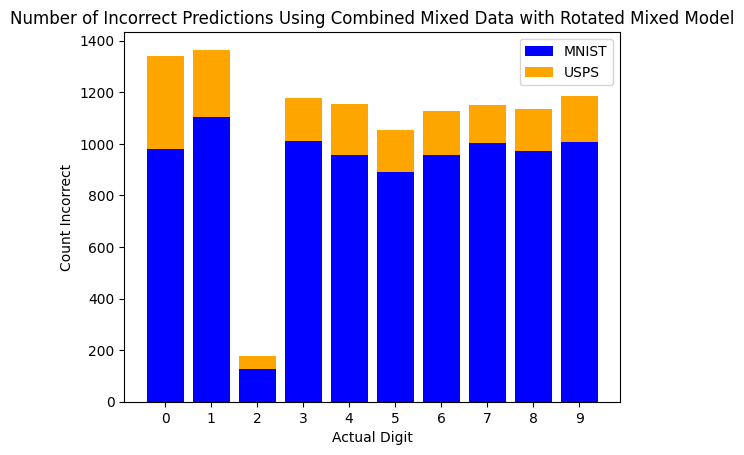

In [67]:
plot_incorrect_2(rotated_mixed_model, mnist_noisy_test_images, usps_noisy_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Mixed Data with Rotated Mixed Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


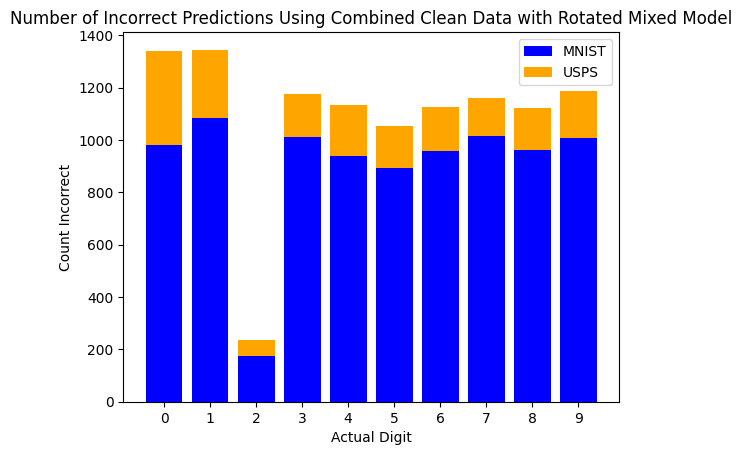

In [68]:
plot_incorrect_2(rotated_mixed_model, mnist_test_images, usps_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Clean Data with Rotated Mixed Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


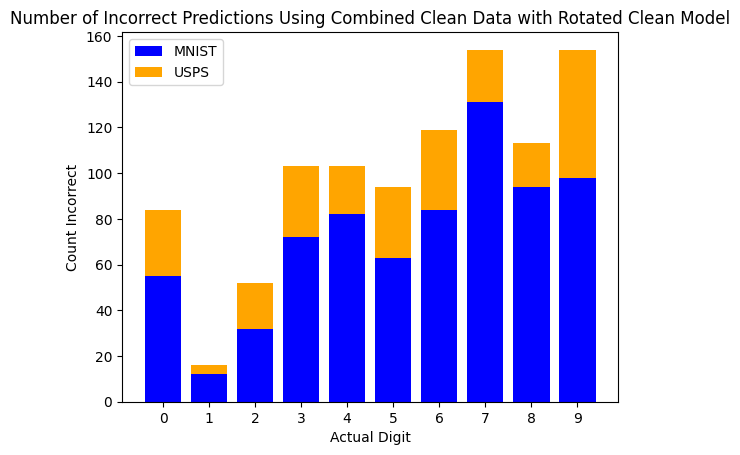

In [69]:
plot_incorrect_2(rotated_clean_model, mnist_test_images, usps_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Clean Data with Rotated Clean Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


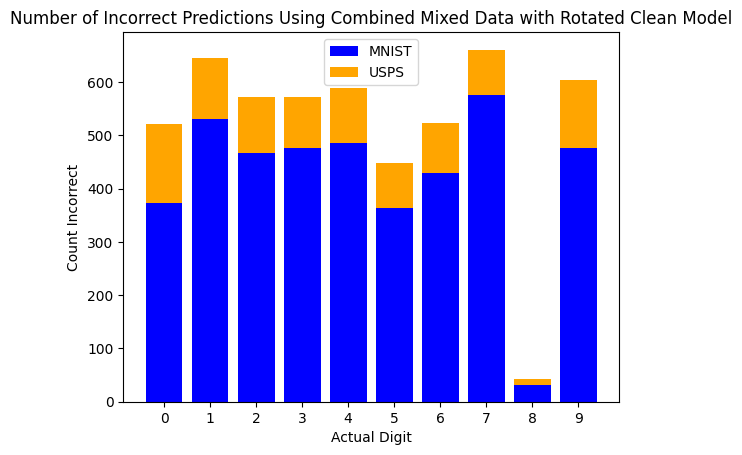

In [70]:
plot_incorrect_2(rotated_clean_model, mnist_noisy_test_images, usps_noisy_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Mixed Data with Rotated Clean Model', 'MNIST', 'USPS')

In [71]:
# function to display incorrect guesses
def display_incorrect(my_model, test_images, test_labels, grid_size, size=3, n_th=0):

  # Find incorrect predictions
  pred = my_model.predict(test_images)
  pred_bin = np.array([np.argmax(x) for x in pred])
  incorrect_pred = np.where(pred_bin != test_labels)
  incorrect_labels = pred_bin[incorrect_pred]
  incorrect_images = test_images[incorrect_pred]
  correct_labels = test_labels[incorrect_pred]

  plot_images_in_grid(incorrect_images, correct_labels, grid_size, size, n_th, incorrect_labels)

376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


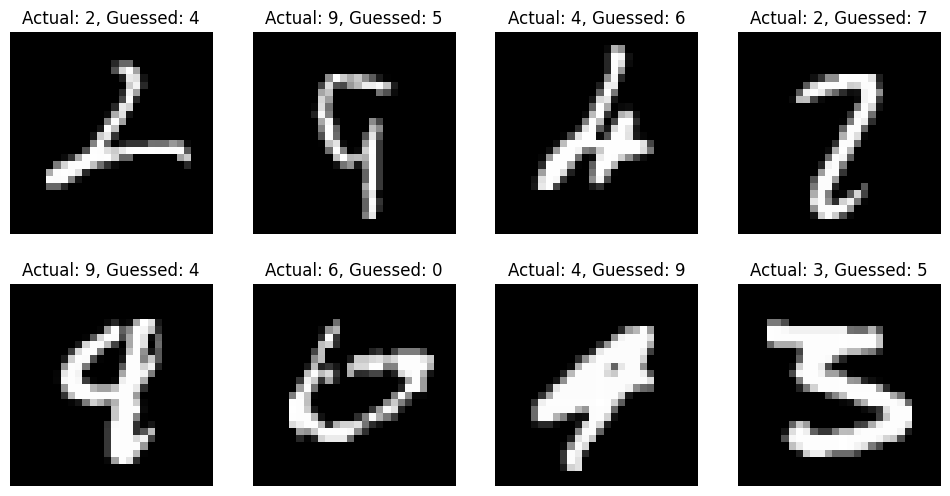

In [72]:
display_incorrect(clean_model, combined_test_images, combined_test_labels, (2, 4))

376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


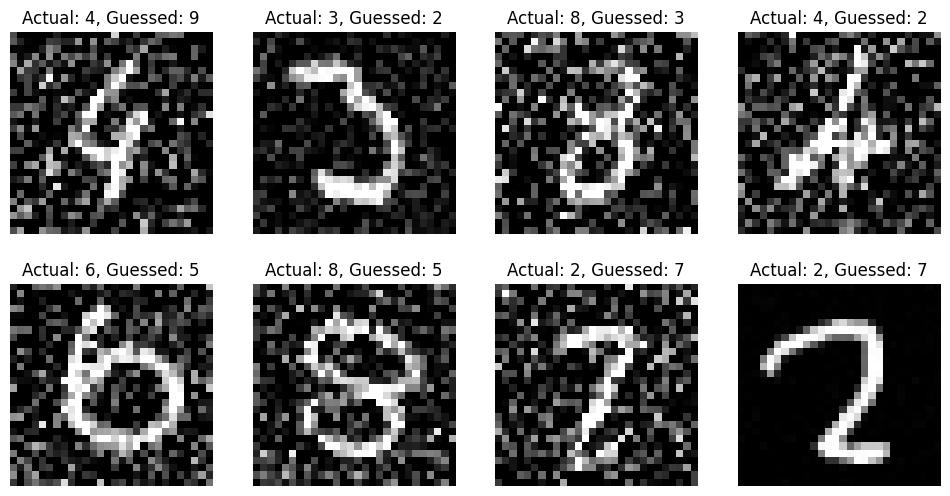

In [73]:
display_incorrect(mixed_model, combined_noisy_test_images, combined_test_labels, (2, 4))

376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


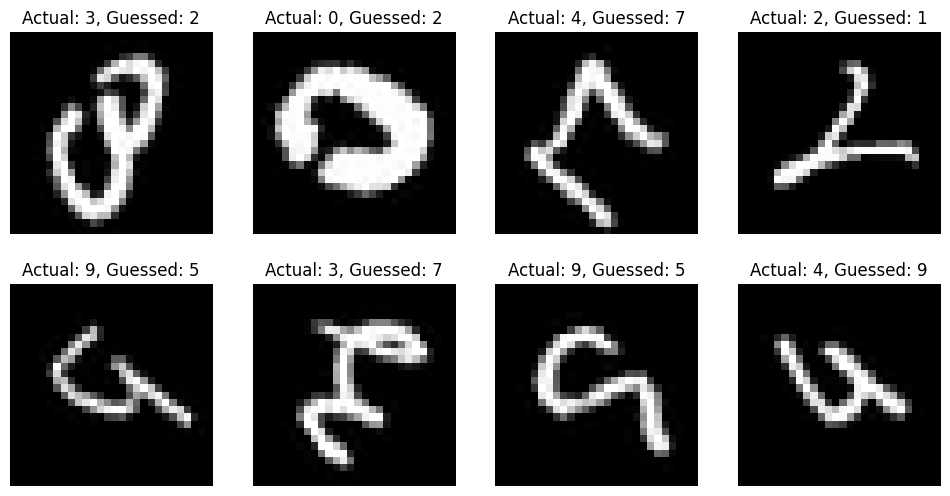

In [74]:
display_incorrect(rotated_clean_model, combined_rotated_test_images, combined_test_labels, (2, 4))

376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


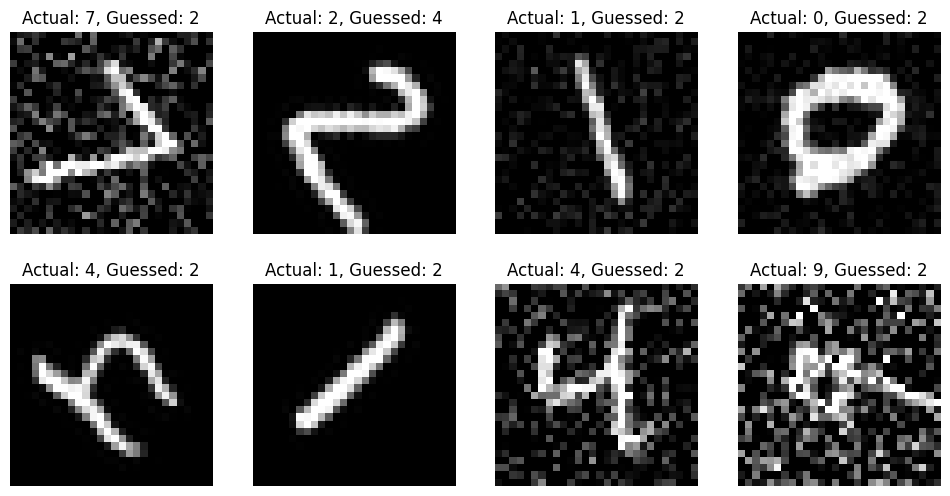

In [75]:
display_incorrect(rotated_mixed_model, combined_rotated_noisy_test_images, combined_test_labels, (2, 4), 3, 0)